# Outliers
Put simply, outliers are data points that diverges from the other data points in a feature. 

![outlier](./outlier.jpg)

## Importance of outliers (anomoly detection)
We've already discussed the importance of removing erroneous data points from your dataset, but the emerging field of anomoly detection had discovered a whole new way of using outliers to make business decisions: 
- Detecting anomolies in heartbeat patterns using smart watches to help predict cardiovascular disease 
- Detecting anomolies in spending patterns to reduce fraudulent transactions
- Monitor system state to prevent downtime in server and network infrastructure

When you have a limited range of data, it's easy to spot the outliers: 

[18,24,22,19,24,18,**5600**,30,29]

However, when dealing with a large dataset, we'll need some more scalable methods for locating and dealing with these data points. 

## Z-Scores
The simplest method for detecting anomolies in your dataset is to examine the standard deviation of each data point from the mean. 
![bell_curve](./bell_curve.png)

For **normally distributed data**, we know that roughly 68% of the population will fall within 1 standard deviation from the mean, and 99.7% will fall within 2 standard deviations. So anything outside of the range should be examined in more detail. 

We can use Z-scores to calculate how far away each datapoint is from the mean: 

    `z = (x – x̄) / s^2` 
Where:  

- x = data point
- x̄ = sample mean
- s^2 = sample standard deviation

Zscore normaliing the feature, as we learned last time, resacles the feature to be centered around the mean, with a standard deviation of 1. Once we've zscore normalized our dataset, outliers should be much easier to detect. 

First we'll create our random dataset: 

In [161]:
import pandas as pd
import numpy as np

# Setting a seed so the example is reproducible 
np.random.seed(42)

# create dataframe from our list of ints
df = pd.DataFrame({"col1":[18,24,22,19,24,18,60,30,29,18,24,22,19,24,18,30,29]}) 
df.head()

,col1
0,18
1,24
2,22
3,19
4,24


1. We use scipy's zscore() function to get the zscores for each data point in a feature: 

In [162]:
from scipy.stats import zscore
df['Zscore'] = zscore(df.col1)

In [163]:
df.head()

,col1,Zscore
0,18,-0.740551
1,24,-0.121402
2,22,-0.327785
3,19,-0.637359
4,24,-0.121402


2. Now we can pull out any Zscores that are above some threshold (typically 2.5 and higher): 

In [164]:
df[abs(df.Zscore) > 2.5]

,col1,Zscore
6,60,3.593493


3. We would need to examine these numbers in more detail depending on our dataset and what kind of questions we are asking. 

## Boxplots
Boxplots allow us to visualize the interquartile ranges of our dataset. When we use the describe method in python: 

In [165]:
df.describe()

,col1,Zscore
count,17.000000,1.700000e+01
mean,25.176471,7.510332e-17
std,9.988964,1.030776e+00
min,18.000000,-7.405509e-01
25%,19.000000,-6.373594e-01
50%,24.000000,-1.214018e-01
75%,29.000000,3.945558e-01
max,60.000000,3.593493e+00


We are calculating the **interquartile range**(IQR = Q3 -Q1), which is another measure of the spread of our dataset that is more robust to outliers than the standard deviation. The inter-quartile range measures the range of the dataset within which 50% of the datapoints fall. 
![boxplot](./box_bell.png)
The whiskers in a boxplot represent the upper and lower bounds of the dataset, where any datapoint beyond these boundaries is more than 3 standard deviations away from the mean. 

We can use pandas to easily create boxplots: 

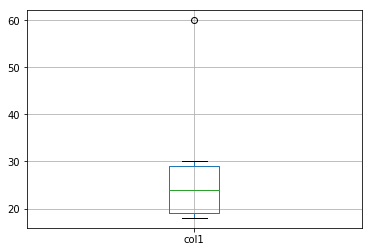

In [166]:
df[["col1"]].boxplot()

## DBSCAN
Rather than using a measuerment of variance, DBSCAN uses a clustering technique that measures the Euclidean distance between points to group together similar points and make it easy to spot points that don't cluster well with others, the outliers. 

DBSCAN assigns points to clusters and return the cluster labels. If it cannot assign the value to any cluster (because it is an outlier), it returns -1.

We'll use sklearn's [DBSCAN()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) function, and plot the results but we'll need a different dataset to see this in action: 

In [171]:
import seaborn as sns
import pandas as pd
titanic = sns.load_dataset('titanic')
titanic = titanic.copy()
titanic = titanic.dropna()
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True


For this example, we'll just pull out the age and fare columns: 

In [183]:
ageAndFare = titanic[["age", "fare"]]

In order to prevent the larger scale of the fare variable from dominating the results, we first need to normalize our columns: 

In [173]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ageAndFare = scaler.fit_transform(ageAndFare)
ageAndFare = pd.DataFrame(ageAndFare, columns = ["age", "fare"])
ageAndFare.head()

,age,fare
0,0.468892,0.139136
1,0.430956,0.103644
2,0.671219,0.101229
3,0.038948,0.032596
4,0.721801,0.051822


And now we can apply the DBSCAN object: 

In [175]:
from sklearn.cluster import DBSCAN

# import DBSCAN model
outlier_detection = DBSCAN()

# fit and predict cluster labels for our column
clusters = outlier_detection.fit_predict(ageAndFare)

In [180]:
ageAndFare['clusters'] = clusters
ageAndFare.head()

,age,fare,clusters
0,0.468892,0.139136,0
1,0.430956,0.103644,0
2,0.671219,0.101229,0
3,0.038948,0.032596,0
4,0.721801,0.051822,0


In [181]:
ageAndFare.clusters.value_counts()

 0    180
-1      2
Name: clusters, dtype: int64

We can see that the algorithm found 2 outliers that it marked with a -1. 

Let's plot the distribution: 

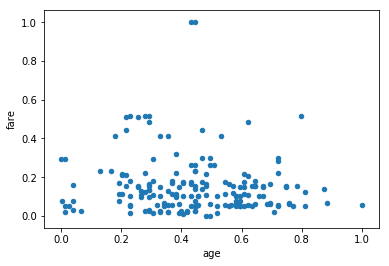

In [182]:
ageAndFare.plot.scatter(x = "age", y = "fare")

And now let's plot our clusters: 

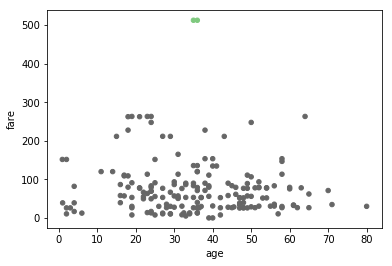

In [184]:
from matplotlib import cm
cmap = cm.get_cmap('Accent')
ageAndFare.plot.scatter(
  x = "age",
  y = "fare",
  c = clusters,
  cmap = cmap,
  colorbar = False
)

And now we can easily see our outliers highlighted in green. 